In [7]:
# Load the necessary python libraries
from sklearn import preprocessing, decomposition, model_selection
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import SVG
import pandas as pd
import numpy as np
import scipy
import random, datetime, os, shutil, math

from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

from PIL import Image


In [8]:
# These are your plotting settings. Change these, rerun this cell and the other cells to see the changes
%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'figure.figsize' : [12,8],
                     })

## Data import 

Hand : 10000
BreastMRI : 8954
ChestCT : 10000
HeadCT : 10000
AbdomenCT : 10000
CXR : 10000


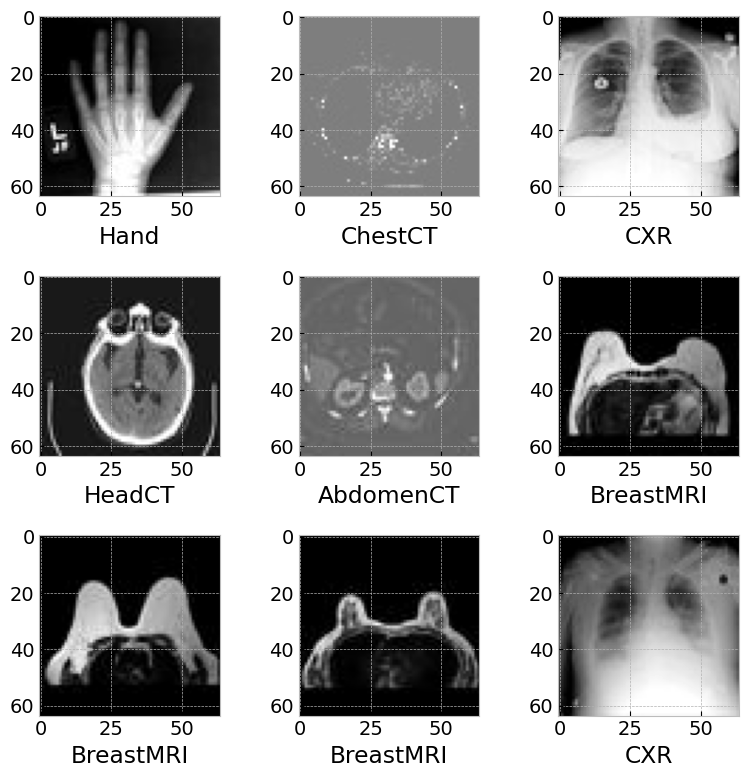

In [9]:
dataDir = 'Medical-MNIST-Classification-master/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames) 


# Number of types = number of subdirectories
imageFilesList=[]
imageClass=[]
for i in range(numClass):
    g=classNames[i]
    if not g.startswith('.'):
        classNamesFolder=os.listdir(os.path.join(dataDir,classNames[i]))
        numClassFolder = len(classNamesFolder) 
        print(classNames[i],":",numClassFolder)
        for x in range(numClassFolder):
            f=classNamesFolder[x]
            if not f.startswith('.'):
                a=os.path.join(dataDir,classNames[i],classNamesFolder[x]) 
                imageFilesList.append(a)
                imageClass.extend([i])
                #imageClass.append(i)
                
numTotal = len(imageFilesList)    
plt.subplots(3,3,figsize=(8,8))    
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    plt.subplot(3,3,i+1)
    
    t=imageFilesList[k]
    pathlist=t.split(os.sep)
    plt.xlabel(pathlist[-2])
    plt.imshow(arr,cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.show()  


# Split the dataset into training, validation and test sets

In [35]:
test_dir = "Medical/Medical_test"
train_dir = "Medical/Medical_train"


image_size = (32, 32, 3)
datagen=ImageDataGenerator(rescale = 1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           validation_split=0.2
                           )

training_set=datagen.flow_from_directory(train_dir,
                                         target_size=image_size[:2],
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=False,
                                         subset='training'
                                         #color_mode='rgb'
                                         )

validation_set = datagen.flow_from_directory(train_dir,
                                         target_size=image_size[:2],
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=False,
                                         subset='validation') 


testing_set=datagen.flow_from_directory(test_dir,
                                           target_size=image_size[:2],
                                           batch_size=32,
                                           class_mode='categorical',
                                           shuffle=False
                                           )



Found 33765 images belonging to 6 classes.
Found 8440 images belonging to 6 classes.
Found 16754 images belonging to 6 classes.


# Convolutional Neural Network (CNN)

In [16]:
def cnn(image_size, num_classes):
    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return classifier

neuralnetwork_cnn = cnn(image_size, num_classes)
neuralnetwork_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                

# Training settings 

In [17]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=7)

Epoch 1/5
1056/1056 [==============================] - ETA: 0s - loss: 0.3333 - acc: 0.8844
Epoch 1: acc improved from -inf to 0.88444, saving model to modelMedicalMNIST.h5
1056/1056 [==============================] - 62s 59ms/step - loss: 0.3333 - acc: 0.8844 - val_loss: 0.0500 - val_acc: 0.9852 - lr: 0.0010
Epoch 2/5
   3/1056 [..............................] - ETA: 34s - loss: 0.0373 - acc: 0.9896

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1056/1056 [==============================] - ETA: 0s - loss: 0.0599 - acc: 0.9842
Epoch 2: acc improved from 0.88444 to 0.98418, saving model to modelMedicalMNIST.h5
1056/1056 [==============================] - 61s 58ms/step - loss: 0.0599 - acc: 0.9842 - val_loss: 0.0384 - val_acc: 0.9905 - lr: 0.0010
Epoch 3/5
1056/1056 [==============================] - ETA: 0s - loss: 0.0202 - acc: 0.9947
Epoch 3: acc improved from 0.98418 to 0.99467, saving model to modelMedicalMNIST.h5
1056/1056 [==============================] - 63s 60ms/step - loss: 0.0202 - acc: 0.9947 - val_loss: 0.0250 - val_acc: 0.9925 - lr: 0.0010
Epoch 4/5
1056/1056 [==============================] - ETA: 0s - loss: 0.0206 - acc: 0.9952
Epoch 4: acc improved from 0.99467 to 0.99520, saving model to modelMedicalMNIST.h5
1056/1056 [==============================] - 57s 54ms/step - loss: 0.0206 - acc: 0.9952 - val_loss: 0.0321 - val_acc: 0.9896 - lr: 0.0010
Epoch 5/5
1056/1056 [==============================] - ETA: 0s - los

# Training the CNN

In [ ]:
history = neuralnetwork_cnn.fit(training_set, epochs=5,validation_data=validation_set,callbacks=[es])

# Training metrics

([<matplotlib.axis.XTick at 0x17b288a90>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

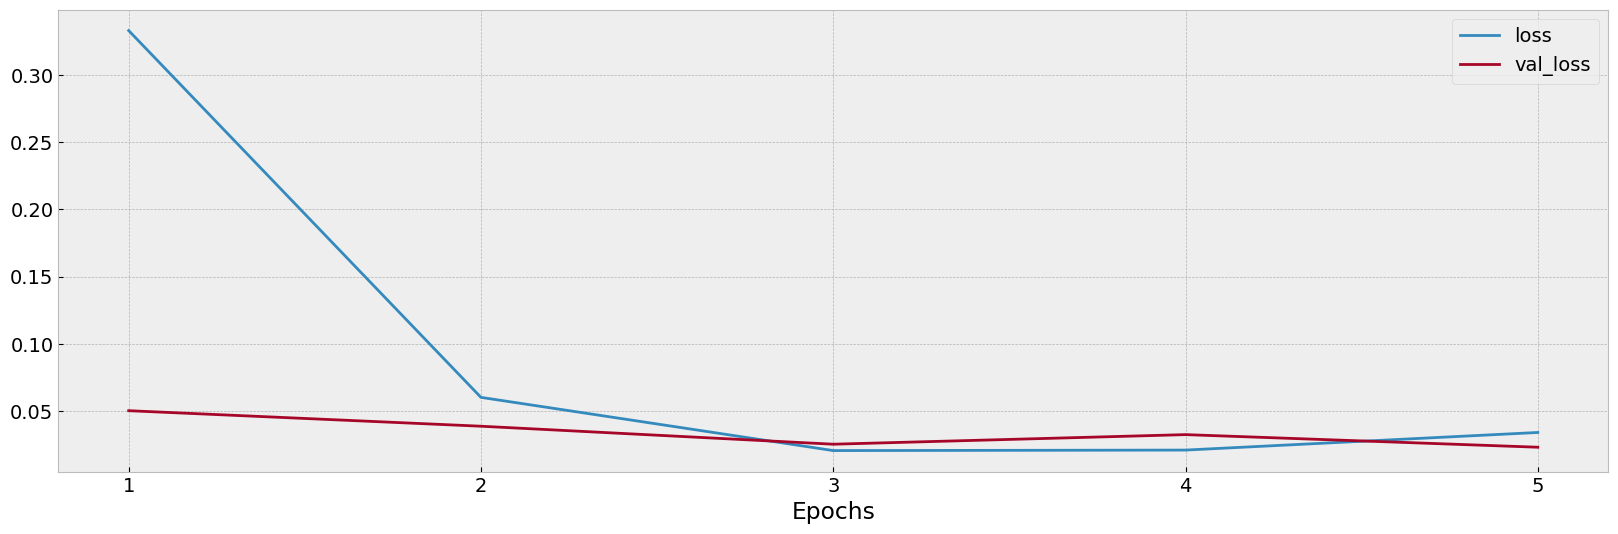

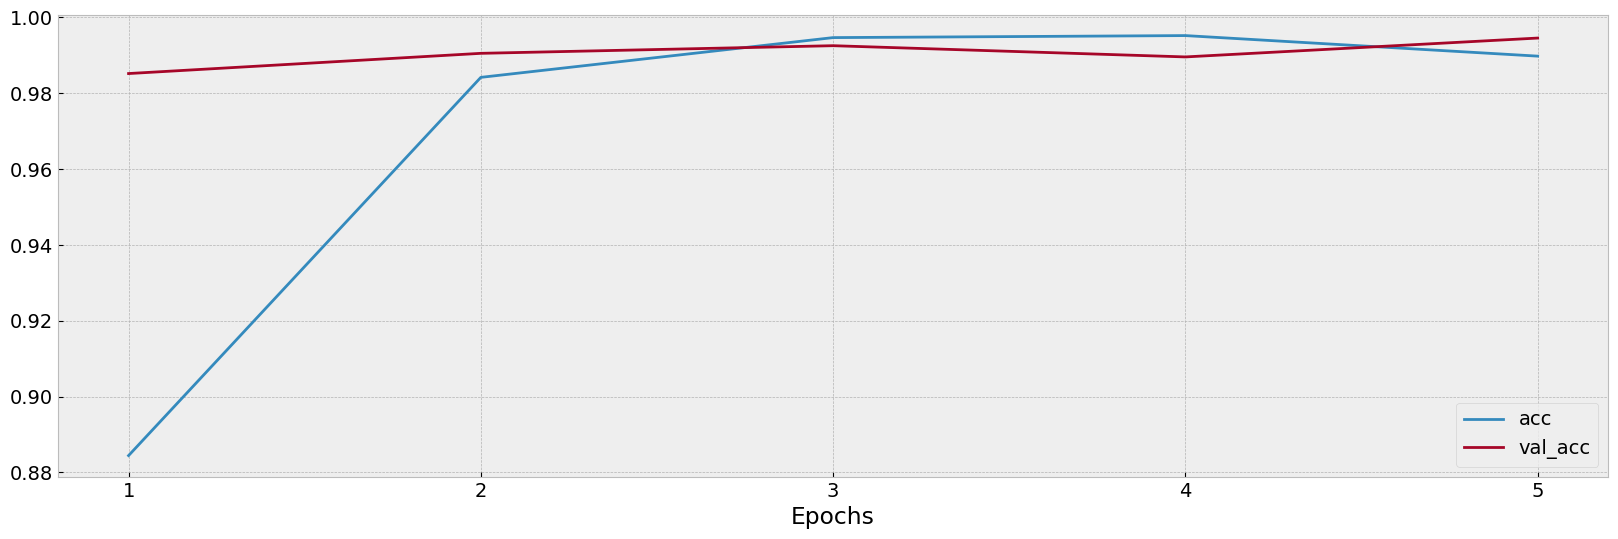

In [38]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, [0,2]].plot(ax=ax)
plt.xlabel('Epochs')
plt.xticks([0, 1, 2, 3, 4], [ 1, 2, 3, 4,5])

fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, [1,3]].plot(ax=ax)
plt.xlabel('Epochs')
plt.xticks([0, 1, 2, 3, 4], [ 1, 2, 3, 4,5])


# Confusion Matrix

524/524 [==============================] - 10s 19ms/step


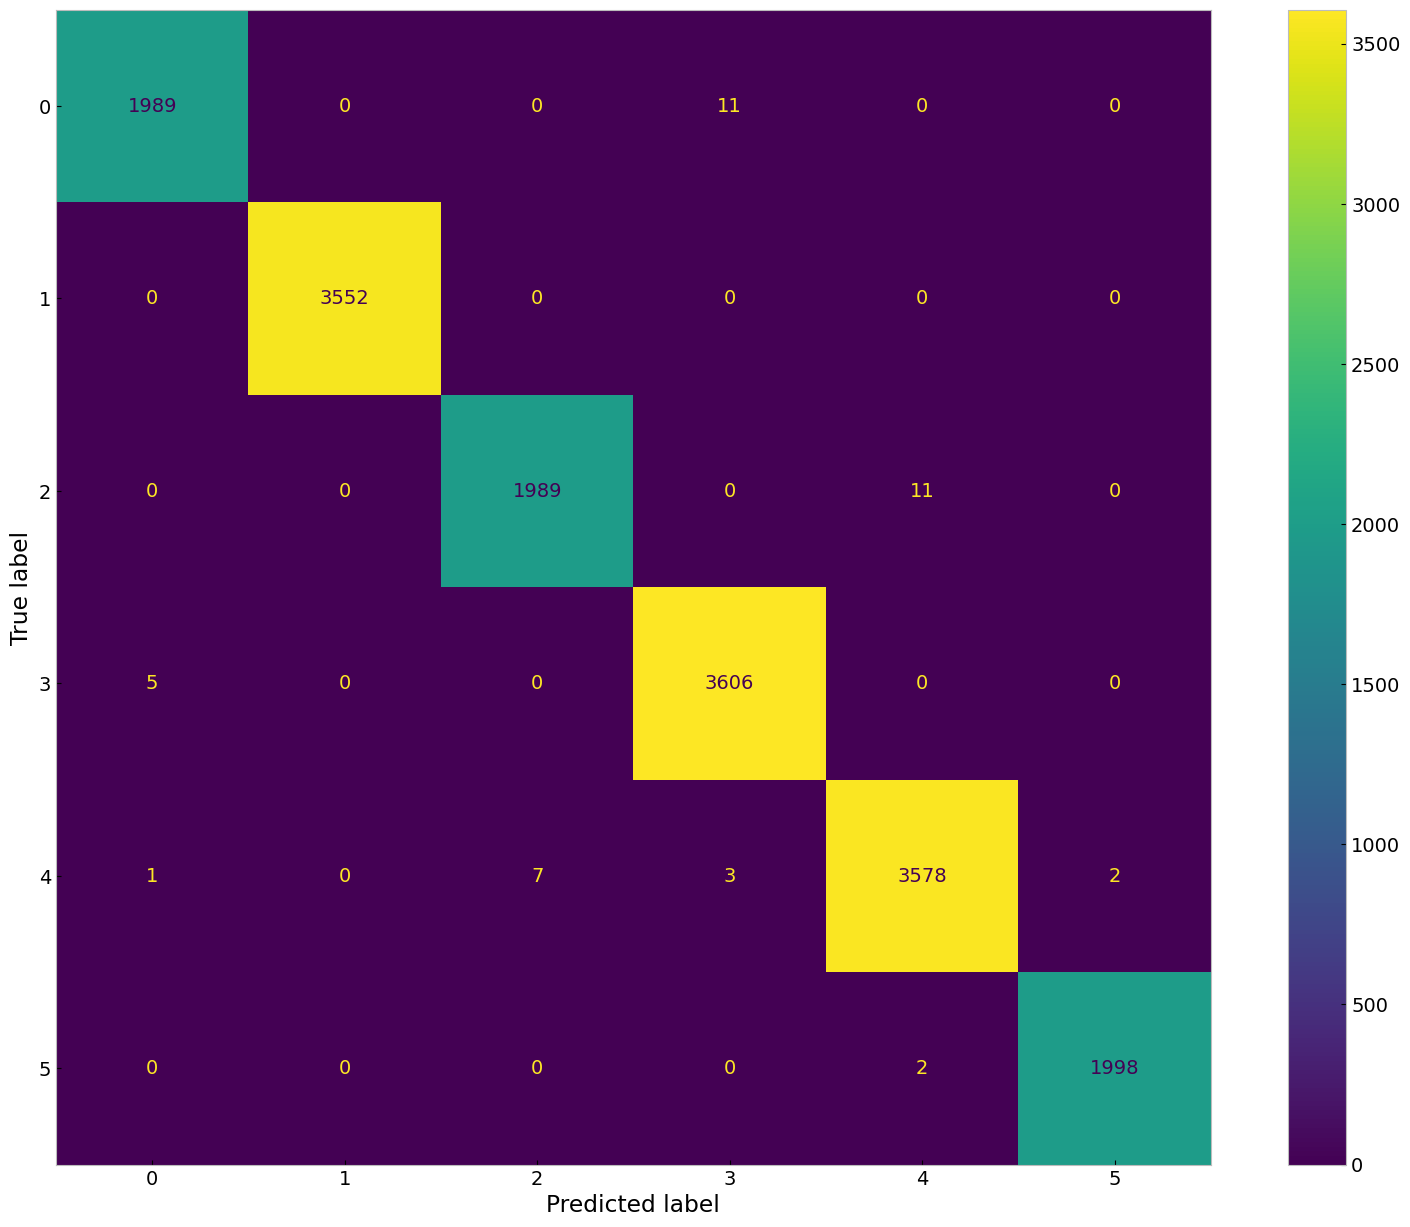

In [27]:
pred=neuralnetwork_cnn.predict(validation_set)
predicted_class_indices=np.argmax(pred,axis=1)
cm=confusion_matrix(testing_set.labels,predicted_class_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig,ax = plt.subplots(figsize=[20,15])
disp.plot(ax=ax)
plt.grid(False)
